In [34]:
#Required Imports
import numpy as np
import pandas as pd
import time
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import f1_score, r2_score, accuracy_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt


class GenAlgo():
    """
    Built to be compatible with sci-kit learn library for both regression and classification models
    This is designed to help with feature selection in highly dimensional datasets.
    """

    def __init__(self, mutation_rate = 0.001, iterations = 100, pool_size = 50):
        """
        This method initialized upon the creation of an instance of the class and takes 3 paramenters:
        mutation rate = a value between 0-1 represent a probability a gen/feature within a solution
                        will mutate.
        iterations = How many genrations the algorithm should produce.
        pool size = How many solutions should we consider each time/iteration.
        """
        self.mutation_rate = mutation_rate
        self.iterations = iterations
        self.pool_size = pool_size
        self.pool = np.array([])
        self.iterations_results = {}
        self.kf = KFold(n_splits=5)


    def results(self):
        """
        Print best results from the fit
        """

        return (self.pool[0], [idx for idx, gene in enumerate(self.pool[0]) if gene==1])


    def plot_progress(self):
        """
        Plots the progress of the genetic algorithm
        """

        avs = [np.mean(self.iterations_results[str(x)]['scores']) for x in range(1,101)]
        avs0 = [np.mean(self.iterations_results[str(x)]['scores'][0]) for x in range(1,101)]
        plt.plot(avs, label='Pool Average Score')
        plt.plot(avs0, label='Best Solution Score')
        plt.legend()
        plt.show()
        
    def extract_genes(self, s, f, i):
        """
        This method is called upon the need to record the score and fitness
        values of each iteration. The return output is a dataframe of the 3
        values. 
        """
        data = dict()
        data['Score'] = s
        data['Fitness'] = f
        data['Iteration number'] = i
        return data
    

    def train(self, model, _type, X, y, cv=True, pca=False, verbose=True):
        """
        model = model object name
        _type = type of model (eg.'regression' or 'classification')
        X = features
        y = labels or target vector
        cv = True/False for cross-validation
        pca = True/False for principal component analysis
        """

        self.__init__(self.mutation_rate, self.iterations, self.pool_size)
        
        is_array = False

        try:
            X = np.array(X)
            is_array = True
        except:
            X = X

        self.pool = np.random.randint(0,2,(self.pool_size, X.shape[1]))

        for iteration in range(1,self.iterations+1):
            s_t = time.time()
            scores = list(); fitness = list(); 
            for chromosome in self.pool:
                chosen_idx = [idx for gene, idx in zip(chromosome, range(X.shape[1])) if gene==1]

                if is_array==True: 
                    adj_X = X[:,chosen_idx]
                elif is_array==False:
                    adj_X = X.iloc[:,chosen_idx]
                    pca==False


                if pca==True:
                    adj_X = PCA(n_components=np.where(np.cumsum(PCA(n_components=adj_X.shape[1]).fit(adj_X).explained_variance_ratio_)>0.90)[0][0]+1).fit_transform(adj_X)

                if _type == 'regression':
                    if cv==True:
                        score = np.mean(cross_val_score(model, adj_X, y, scoring='r2', cv=self.kf))
                    else:
                        score = r2_score(y, model.fit(adj_X,y).predict(adj_X))

                elif _type == 'classification':
                    if cv==True:
                        score = np.mean(cross_val_score(model, adj_X, y, scoring='f1_weighted', cv=self.kf))
                    else:
                        score = accuracy_score(y, model.fit(adj_X,y).predict(adj_X))

                scores.append(score)
            fitness = [x/sum(scores) for x in scores]
            #print (score, fitness)
            #records = extract_genes(self, score, fitness, iteration)
            #logs = pd.DataFrame()
            #logs['Score'] = scores
            #logs['Fitness'] = fitness
            #logs['Iteration number'] = iteration

            fitness, self.pool, scores = (list(t) for t in zip(*sorted(zip(fitness, [list(l) for l in list(self.pool)], scores),reverse=True)))
            self.iterations_results['{}'.format(iteration)] = dict()
            self.iterations_results['{}'.format(iteration)]['fitness'] = fitness
            self.iterations_results['{}'.format(iteration)]['pool'] = self.pool
            self.iterations_results['{}'.format(iteration)]['scores'] = scores

            self.pool = np.array(self.pool)

            if iteration != self.iterations+1:
                new_pool = []
                for chromosome in self.pool[1:int((len(self.pool)/2)+1)]:
                    random_split_point = np.random.randint(1,len(chromosome))
                    next_gen1 = np.concatenate((self.pool[0][:random_split_point], chromosome[random_split_point:]), axis = 0)
                    next_gen2 = np.concatenate((chromosome[:random_split_point], self.pool[0][random_split_point:]), axis = 0)
                    for idx, gene in enumerate(next_gen1):
                        if np.random.random() < self.mutation_rate:
                            next_gen1[idx] = 1 if gene==0 else 0
                    for idx, gene in enumerate(next_gen2):
                        if np.random.random() < self.mutation_rate:
                            next_gen2[idx] = 1 if gene==0 else 0
                    new_pool.append(next_gen1)
                    new_pool.append(next_gen2)
                self.pool = new_pool
            else:
                continue
            if verbose:
                if iteration % 10 == 0:
                    e_t = time.time()
                    print('Iteration {} Complete [Time Taken For Last Iteration: {} Seconds]'.format(iteration,round(e_t-s_t,2)))

# PCA variance = 0.70

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Iteration 10 Complete [Time Taken For Last Iteration: 1.26 Seconds]
Iteration 20 Complete [Time Taken For Last Iteration: 1.29 Seconds]
Iteration 30 Complete [Time Taken For Last Iteration: 1.26 Seconds]
Iteration 40 Complete [Time Taken For Last Iteration: 1.25 Seconds]
Iteration 50 Complete [Time Taken For Last Iteration: 1.26 Seconds]
Iteration 60 Complete [Time Taken For Last Iteration: 1.24 Seconds]
Iteration 70 Complete [Time Taken For Last Iteration: 1.28 Seconds]
Iteration 80 Complete [Time Taken For Last Iteration: 1.28 Seconds]
Iteration 90 Complete [Time Taken For Last Iteration: 1.27 Seconds]
Iteration 100 Complete [Time Taken For Last Iteration: 1.28 Seconds]


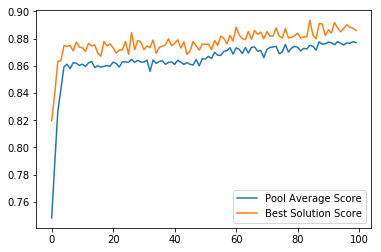

In [25]:
#from genalgo import GenAlgo
from sklearn.linear_model import LinearRegression
from sklearn.datasets import load_digits
from sklearn.linear_model import SGDClassifier

# Initialize the model
logistic = SGDClassifier(loss='log', penalty='l2',max_iter=1000, tol=1e-5, random_state=0)
# Initialize object of the Gen Algorithm
gfs = GenAlgo(mutation_rate = 0.001, iterations = 100, pool_size = 16)
# Dummy Dataset
digits = load_digits()

# Train the Algorithm
gfs.train(model=logistic, _type='classification', X=digits.data, y=digits.target, pca = True) # regression model

# get results output
binary_output_of_optimal_variables, indicies_of_optimal_variables = gfs.results()

# Visualize the performance
gfs.plot_progress()

In [28]:
from numpy import array

def ClassificationScore(gen):
    rawlogs = gfs.iterations_results
    rawlogsDF = pd.DataFrame(rawlogs)
    rawlogsDF = rawlogsDF.transpose()
    rawlogsDF.columns = ['Fitness', 'Pool', 'Scores']
    Scores = rawlogsDF.Scores[gen]
    Scores = rawlogsDF.Scores[gen]
    Scores = array(Scores)
    score = Scores.max()
    s = score*100
    
    
    return print("Highest Score (accuracy) in the {0} iteration = {1}%".format(gen,"%.2f"%s))

In [31]:
ClassificationScore(70)
ClassificationScore(75)
ClassificationScore(80)
ClassificationScore(85)
ClassificationScore(90)


Highest Score (accuracy) in the 70 iteration = 88.18%
Highest Score (accuracy) in the 75 iteration = 88.74%
Highest Score (accuracy) in the 80 iteration = 88.39%
Highest Score (accuracy) in the 85 iteration = 88.24%
Highest Score (accuracy) in the 90 iteration = 88.22%


In [32]:
#The best features
features, genes = gfs.results()

In [33]:
# basically which features are the best, 1= choosen, 0= not
print(len(features))
print(features)

64
[0 1 1 1 1 1 1 0 1 0 0 1 1 0 0 1 0 1 1 1 0 1 1 0 0 1 1 1 0 1 1 0 0 1 0 1 1
 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 0 1 1 0 0 1 1 1 1 1]


In [23]:
# which are the chosen feautres
print(len(genes))
print(genes)

39
[0, 2, 3, 4, 5, 6, 11, 12, 13, 14, 17, 19, 20, 21, 24, 25, 26, 27, 28, 30, 31, 32, 34, 35, 36, 38, 41, 42, 43, 44, 45, 47, 48, 49, 51, 52, 53, 56, 61]


**You must ask why 46 features only have been selected?**

Because among the 50 features we have passed to the algorithm the PCA reduced them into 46.

# PCA variance = 0.90

Iteration 10 Complete [Time Taken For Last Iteration: 1.73 Seconds]
Iteration 20 Complete [Time Taken For Last Iteration: 1.36 Seconds]
Iteration 30 Complete [Time Taken For Last Iteration: 1.35 Seconds]
Iteration 40 Complete [Time Taken For Last Iteration: 1.34 Seconds]
Iteration 50 Complete [Time Taken For Last Iteration: 1.38 Seconds]
Iteration 60 Complete [Time Taken For Last Iteration: 1.38 Seconds]
Iteration 70 Complete [Time Taken For Last Iteration: 1.4 Seconds]
Iteration 80 Complete [Time Taken For Last Iteration: 1.39 Seconds]
Iteration 90 Complete [Time Taken For Last Iteration: 1.35 Seconds]
Iteration 100 Complete [Time Taken For Last Iteration: 1.4 Seconds]


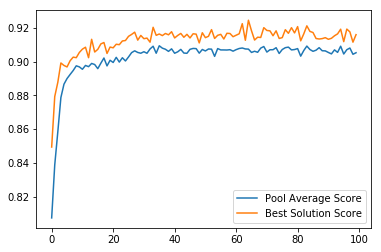

In [35]:
#from genalgo import GenAlgo
from sklearn.linear_model import LinearRegression
from sklearn.datasets import load_digits
from sklearn.linear_model import SGDClassifier

# Initialize the model
logistic = SGDClassifier(loss='log', penalty='l2',max_iter=1000, tol=1e-5, random_state=0)
# Initialize object of the Gen Algorithm
gfs = GenAlgo(mutation_rate = 0.001, iterations = 100, pool_size = 16)
# Dummy Dataset
digits = load_digits()

# Train the Algorithm
gfs.train(model=logistic, _type='classification', X=digits.data, y=digits.target, pca = True) # regression model

# get results output
binary_output_of_optimal_variables, indicies_of_optimal_variables = gfs.results()

# Visualize the performance
gfs.plot_progress()